In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import h5py
import scipy

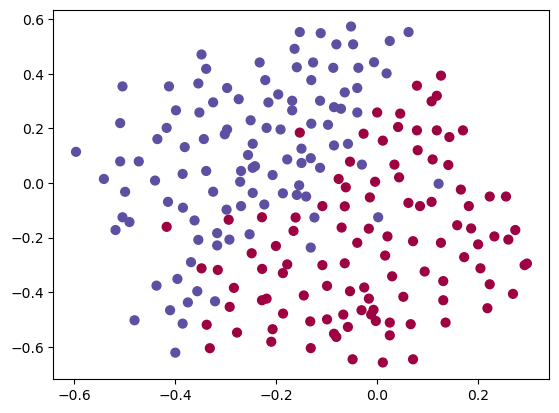

In [127]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [197]:
def init_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        #parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [48]:
def sigmoid_func(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu_func(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

In [16]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, act_func):
    if act_func == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid_func(Z)

    elif act_func == 'relu':
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu_func(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

def NN_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], act_func='relu')
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], act_func='sigmoid')
    caches.append(cache)

    return AL, caches

In [136]:
def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward_d(A_prev, W, b,drop_prob ,act_func):
    Z, linear_cache = linear_forward(A_prev,W,b)
    if act_func == 'sigmoid':
        A, activation_cache = sigmoid_func(Z)

    elif act_func == 'relu':
        A, activation_cache = relu_func(Z)
        
    
    #cache = (linear_cache, activation_cache)

    return A, linear_cache, activation_cache

def forwar_prog(X, parameters, drop_prob = 0.5):
    caches=[]
    A = X
    L = len(parameters)//2
    np.random.seed(1)
    for l in range(1,L):
        A_prev = A
        A, linear_cache, activation_cache = linear_activation_forward_d(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], drop_prob, act_func='relu')
        D = np.random.rand(A.shape[0], A.shape[1])
        D = D < drop_prob
        A = np.multiply(D,A)
        A = A/drop_prob
        cache = (linear_cache, activation_cache,D)
        caches.append(cache)
        
    AL, linear_cache, activation_cache = linear_activation_forward_d(A, parameters['W' + str(L)], parameters['b' + str(L)], drop_prob , act_func='sigmoid')
    cache = (linear_cache, activation_cache,D)
    caches.append(cache)

    return AL, caches

In [151]:
def compute_cost(AL, Y):
    epsilon = 1e-15
    """m = Y.shape[1]
    cost = np.dot((Y*np.log(AL) + (1-Y)*np.log(1-AL)),np.ones((m,1)))*(-1/m)
    cost = np.squeeze(cost)"""
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(AL+ epsilon),Y) + np.multiply(-np.log(1 - AL + epsilon), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost

def compute_with_reg(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    tmp_sum = 0
    for l in range(1,L+1):
        tmp_sum = np.sum(np.square(parameters['W'+str(l)])) + tmp_sum
    L2_cost = lambd*tmp_sum/(2*m)
    cost = compute_cost(AL, Y)
    total_cost = cost + L2_cost
    return total_cost

In [50]:
def relu_backward_func(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward_func(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [84]:
def linear_backward(dZ, cache, lambd=0):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m + lambd*W/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db 

def linear_activation_backward(dA, cache, act_func,lambd=0):
    linear_cache, activation_cache = cache
    if act_func == 'relu':
        dZ = relu_backward_func(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd=lambd)
    elif act_func == 'sigmoid':
        dZ = sigmoid_backward_func(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd=lambd)
    return dA_prev, dW, db


def NN_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y, AL) -np.divide(1 - Y, 1-AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, act_func='sigmoid')
    grads['dA' + str(L-1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, act_func='relu')
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l + 1)] = dW_temp
        grads['db' + str(l + 1)] = db_temp
        
        
    return grads

def NN_model_backward_with_reg(AL, Y, caches,lambd):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y, AL) -np.divide(1 - Y, 1-AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, act_func='sigmoid',lambd=lambd)
    grads['dA' + str(L-1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, act_func='relu',lambd=lambd)
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l + 1)] = dW_temp
        grads['db' + str(l + 1)] = db_temp
        
        
    return grads

In [150]:
def linear_backward_d(dZ, cache, drop_prob=0):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db 

def linear_activation_backward_d(dA, cache, act_func,drop_prob=0):
    linear_cache, activation_cache = cache
    if act_func == 'relu':
        dZ = relu_backward_func(dA, activation_cache)
        dA_prev, dW, db = linear_backward_d(dZ, linear_cache, drop_prob=drop_prob)
    elif act_func == 'sigmoid':
        dZ = sigmoid_backward_func(dA, activation_cache)
        dA_prev, dW, db = linear_backward_d(dZ, linear_cache, drop_prob=drop_prob)
    return dA_prev, dW, db

def back_prog(AL, Y, caches, drop_prob):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    epsilon = 1e-15
    dAL = -(np.divide(Y, AL + epsilon) -np.divide(1 - Y, 1-AL + epsilon))

    linear_cache, activation_cache, D = caches[L-1]
    
    current_cache = (linear_cache, activation_cache)
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward_d(dAL, current_cache, act_func='sigmoid',drop_prob=drop_prob)
    #grads['dA' + str(L-1)] = dA_prev_temp
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    #print("S",D.shape,dA_prev_temp.shape,dAL.shape)
    
    
    for l in reversed(range(L-1)):
        linear_cache, activation_cache, D = caches[l]
        
        dA_prev_temp = np.multiply(D, dA_prev_temp)
        dA_prev_temp = dA_prev_temp/drop_prob
        grads['dA' + str(l+1)] = dA_prev_temp
        
        
        current_cache = (linear_cache, activation_cache)
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward_d(dA_prev_temp, current_cache, act_func='relu',drop_prob=drop_prob)
       
        #grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l + 1)] = dW_temp
        grads['db' + str(l + 1)] = db_temp
        
    return grads

In [53]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2
    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - grads['dW' + str(l+1)]*learning_rate
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - grads['db' + str(l+1)]*learning_rate
    
    return parameters

In [120]:
def NN_model(X,Y, layers_dims, learning_rate = 0.0075, iter_no = 1000000, pr_cost = False):
    np.random.seed(1)
    costs=[]
    parameters = init_parameters(layers_dims)
    for i in range(0, iter_no):
        AL, caches = NN_model_forward(X, parameters)
        cost = compute_cost(AL,Y)
        grads = NN_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
        if pr_cost and i%1000 == 0 or i == iter_no-1:
            print("{} - Cost = {}".format(i,np.squeeze(cost)))
        if i%1000 == 0 or i == iter_no:
            costs.append(cost)
    return parameters, costs

In [55]:
def NN_model_R(X,Y, layers_dims, lambd=0,learning_rate = 0.0075, iter_no = 1000000, pr_cost = False):
    np.random.seed(1)
    costs=[]
    parameters = init_parameters(layers_dims)
    for i in range(0, iter_no):
        AL, caches = NN_model_forward(X, parameters)
        cost = compute_with_reg(AL,Y,parameters,lambd)
        grads = NN_model_backward_with_reg(AL, Y, caches,lambd)
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
        if pr_cost and i%5000 == 0 or i == iter_no-1:
            print("{} - Cost = {}".format(i,np.squeeze(cost)))
        if i%1000 == 0 or i == iter_no:
            costs.append(cost)
    return parameters, costs

In [229]:
def NN_model_D(X,Y, layers_dims, drop_prob=1,learning_rate = 0.3, iter_no = 30000, pr_cost = False):
    np.random.seed(1)
    costs=[]
    parameters = init_parameters(layers_dims)
    for i in range(0, iter_no):
        AL, caches = forwar_prog(X, parameters, drop_prob)
        for i in caches:
            print("122",len(i[0]),i[1].shape,i[2].shape)
        print(len(caches),len(caches[0]),len(caches[0][0]))
        cost = compute_cost(AL,Y)
        grads = back_prog(AL, Y, caches,drop_prob)
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
        if pr_cost and i%5000 == 0 or i == iter_no-1:
            print("{} - Cost = {}".format(i,np.squeeze(cost)))
        if i%1000 == 0 or i == iter_no:
            costs.append(cost)
    return parameters, costs

In [232]:
def deep_NN(X,Y, layers_dims, learning_rate = 0.3, iter_no = 30000, pr_cost = False, drop_prob=1, lambd=0):
    np.random.seed(1)
    costs=[]
    parameters = init_parameters(layers_dims)
    for i in range(0, iter_no):
        if drop_prob == 1:
            AL, caches = forwar_prog(X, parameters, drop_prob)
        else:
            AL, caches = forwar_prog(X, parameters, drop_prob)

        if lambd == 0:
            cost = compute_cost(AL,Y)
        else:
            cost = compute_with_reg(AL, Y, paramerers,lambd)

        if lambd == 0 and drop_prob == 1:
            grads = back_prog(AL, Y, caches,drop_prob)
        elif lambd != 0:
            grads = back_prog(AL, Y, caches,drop_prob)
        elif drop_prob < 0:
            grads = back_prog(AL, Y, caches,drop_prob)
            
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
        
        if pr_cost and i%1000 == 0 or i == iter_no-1:
            print("{} - Cost = {}".format(i,np.squeeze(cost)))
        if i%1000 == 0 or i == iter_no:
            costs.append(cost)
    return parameters, costs

In [57]:
def predict_test(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    probas, caches = NN_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [58]:
def prepare_data(df):
    X = df.drop(columns = 'Survived').values
    y = df['Survived'].values.reshape((-1,1))
    maxX = np.max(X,axis=0)
    X=X/maxX
    return X.T,y.T
def prepare_test_data(df):
    X = df.values
    maxX = np.max(X,axis=0)
    X=X/maxX
    return X.T

In [153]:
df = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

In [154]:
df.drop(columns='Cabin', inplace= True)
df_test.drop(columns='Cabin', inplace= True)

df.drop(columns='Name', inplace= True)
df_test.drop(columns='Name', inplace= True)

df.drop(columns='PassengerId', inplace= True)
df_test.drop(columns='PassengerId', inplace= True)

df.drop(columns='Ticket', inplace= True)
df_test.drop(columns='Ticket', inplace= True)

In [155]:
df.loc[df['Pclass'] == 1, 'Age'] = df.loc[df['Pclass'] == 1, 'Age'].fillna(df[df['Pclass'] == 1]['Age'].mean())
df.loc[df['Pclass'] == 2, 'Age'] = df.loc[df['Pclass'] == 2, 'Age'].fillna(df[df['Pclass'] == 2]['Age'].mean())
df.loc[df['Pclass'] == 3, 'Age'] = df.loc[df['Pclass'] == 3, 'Age'].fillna(df[df['Pclass'] == 3]['Age'].mean())
df['Embarked'] = df['Embarked'].fillna('S')

df_test.loc[df_test['Pclass'] == 1, 'Age'] = df_test.loc[df_test['Pclass'] == 1, 'Age'].fillna(df_test[df_test['Pclass'] == 1]['Age'].mean())
df_test.loc[df_test['Pclass'] == 2, 'Age'] = df_test.loc[df_test['Pclass'] == 2, 'Age'].fillna(df_test[df_test['Pclass'] == 2]['Age'].mean())
df_test.loc[df_test['Pclass'] == 3, 'Age'] = df_test.loc[df_test['Pclass'] == 3, 'Age'].fillna(df_test[df_test['Pclass'] == 3]['Age'].mean())

df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

In [156]:
df['Fare']=df['Fare']/(df['SibSp'] + df['Parch'] +1)
df_test['Fare']=df_test['Fare']/(df_test['SibSp'] + df_test['Parch'] +1)

In [157]:
print(df.isnull().sum(),df_test.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [158]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()
        df[label] = pd.Categorical(content).codes

for label, content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_test[label] = content.astype("category").cat.as_ordered()
        df_test[label] = pd.Categorical(content).codes

In [159]:
df['S_P_W']=df['Pclass']*df['Pclass']*(df['Sex'] + 1)
df_test['S_P_W']=df_test['Pclass']*df_test['Pclass']*(df_test['Sex'] + 1)

In [218]:
#np.random.seed(0)
valid = df.sample(n = int(len(df)*0.3),random_state=1)
train = df.drop(valid.index)

In [219]:
X_train, y_train = prepare_data(train)
X_valid, y_valid = prepare_data(valid)
X_Train, y_Train = prepare_data(df)
test = prepare_test_data(df_test)

In [220]:
layer_dims_dev=[X_train.shape[0],21,12,5,1]
layer_dims=[X_train.shape[0],25,13,6,1]

In [230]:
paramerers, cache = NN_model_R(X_train,y_train,layer_dims,lambd=0.0,learning_rate=0.003,iter_no=20000,pr_cost=True)

0 - Cost = 0.7139752599303616
5000 - Cost = 0.6200675042315131
10000 - Cost = 0.49422542379605533
15000 - Cost = 0.4383322222753748
19999 - Cost = 0.41610299328127354


In [232]:
paramerers, cache = NN_model_R(X_train,y_train,layer_dims,lambd=0.8,learning_rate=0.003,iter_no=20000,pr_cost=True)

0 - Cost = 0.7431543582349303
5000 - Cost = 0.6518357588360796
10000 - Cost = 0.5242824492966401
15000 - Cost = 0.4712969422292612
19999 - Cost = 0.4519062283359423


In [231]:
pred_T = predict_test(X_train,y_train,paramerers)
_ = predict_test(X_train,1,paramerers).astype(int)
pred_V = predict_test(X_valid,y_valid,paramerers)
_ = predict_test(X_valid,1,paramerers).astype(int)

Accuracy: 0.8253205128205127
Accuracy: 0.3301282051282051
Accuracy: 0.8089887640449439
Accuracy: 0.352059925093633


In [233]:
pred_T = predict_test(X_train,y_train,paramerers)
_ = predict_test(X_train,1,paramerers).astype(int)
pred_V = predict_test(X_valid,y_valid,paramerers)
_ = predict_test(X_valid,1,paramerers).astype(int)

Accuracy: 0.8221153846153845
Accuracy: 0.3269230769230769
Accuracy: 0.8089887640449439
Accuracy: 0.3445692883895131


In [214]:
paramerers, cache = NN_model_R(X_Train,y_Train,layer_dims,lambd=0.7,learning_rate=0.0025,iter_no=20000,pr_cost=True)

0 - Cost = 0.7312811251868411
5000 - Cost = 0.665889840316263
10000 - Cost = 0.5588299033069399
15000 - Cost = 0.49224814476824036
19999 - Cost = 0.45728110721546983


In [215]:
prediction = predict_test(test,1,paramerers).astype(int)

Accuracy: 0.3492822966507177


In [216]:
write= pd.read_csv("Data/test.csv")
result=pd.DataFrame({"PassengerId":write['PassengerId'],"Survived":prediction[0]})
result.to_csv("resultNN.csv", index=False)

In [217]:
prediction

array([[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [62]:
layers_dims = [train_X.shape[0], 20, 3, 1]
train_X.shape

(2, 211)

In [152]:
paramerers, cache = NN_model_D(train_X, train_Y, layers_dims, drop_prob=0.86,learning_rate=0.3,pr_cost=True)

(20, 2) (20, 1)
(3, 20) (3, 1)
(1, 3) (1, 1)
6
0 - Cost = 0.6543912405149807
1000 - Cost = 0.1759784892976795
2000 - Cost = 0.10396707442901737
3000 - Cost = 0.07661297787357763
4000 - Cost = 0.06719891269813837
5000 - Cost = 0.06466905008519795
6000 - Cost = 0.062409872596981775
7000 - Cost = 0.0618787353131578
8000 - Cost = 0.06143321815249701
9000 - Cost = 0.06119214375763379
10000 - Cost = 0.061016986574904536
11000 - Cost = 0.06093245082616729
12000 - Cost = 0.060826401965959925
13000 - Cost = 0.060862641299848426
14000 - Cost = 0.060835215370211145
15000 - Cost = 0.06066457216128679
16000 - Cost = 0.060649472377480314
17000 - Cost = 0.06062585662115614
18000 - Cost = 0.06065874505596555
19000 - Cost = 0.06059651330299828
20000 - Cost = 0.060582435798512024
21000 - Cost = 0.06055919938091206
22000 - Cost = 0.060578983901563715
23000 - Cost = 0.060564614663728235
24000 - Cost = 0.06050359026993098
25000 - Cost = 0.060501790023623755
26000 - Cost = 0.06052211741257197
27000 - Cost =

In [185]:
#paramerers, cache = NN_model_D(X_train, y_train, layers_dims, drop_prob=0.86,learning_rate=0.3,pr_cost=True)

In [226]:
paramerers, cache = NN_model_D(X_train, y_train, layer_dims, drop_prob=0.8,learning_rate=0.1,iter_no=7000,pr_cost=True)

0 - Cost = 0.7169470206451966
1000 - Cost = 0.3900287252743571
2000 - Cost = 0.31217248076157394
3000 - Cost = 0.2498941772373947
4000 - Cost = 0.1783484950777571
5000 - Cost = 0.13766976433631
6000 - Cost = 0.11741186385905804
6999 - Cost = 0.10451232276013532


In [225]:
paramerers2, cache = NN_model_D(X_train, y_train, layer_dims, drop_prob=1,learning_rate=0.1,iter_no=7000,pr_cost=True)

0 - Cost = 0.7158494462139091
1000 - Cost = 0.37241129505369264
2000 - Cost = 0.35312048072690977
3000 - Cost = 0.3469080835088909
4000 - Cost = 0.33673536051986386
5000 - Cost = 0.33952321396191254
6000 - Cost = 0.33078392158010905
6999 - Cost = 0.3090139583915178


In [227]:
pred_T = predict_test(X_train,y_train,paramerers)
_ = predict_test(X_train,1,paramerers).astype(int)
pred_V = predict_test(X_valid,y_valid,paramerers)
_ = predict_test(X_valid,1,paramerers).astype(int)

Accuracy: 0.8381410256410254
Accuracy: 0.24679487179487178
Accuracy: 0.7677902621722846
Accuracy: 0.26591760299625467


In [228]:
pred_T = predict_test(X_train,y_train,paramerers2)
_ = predict_test(X_train,1,paramerers2).astype(int)
pred_V = predict_test(X_valid,y_valid,paramerers2)
_ = predict_test(X_valid,1,paramerers2).astype(int)

Accuracy: 0.8830128205128203
Accuracy: 0.27884615384615385
Accuracy: 0.752808988764045
Accuracy: 0.2958801498127341


In [175]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forwar_prog(X, parameters)
    predictions = (a3>0.5)
    return predictions